# Visualizing the data

-------
Let's take a closer look at the data.

In [2]:
import os
import cv2

In [3]:
data_dir= "/content/drive/MyDrive/Colab Notebooks/AutismDataset"

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
os.listdir(data_dir)

['train', 'valid', 'consolidated', 'test']

We import the necessary libraries 

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf


In [7]:
from matplotlib.image import imread
%matplotlib inline

In [8]:
test_path= data_dir+"/test"
val_path= data_dir+"/valid"
train_path= data_dir+"/train"

In [9]:
os.listdir(test_path)

['Autistic', 'Non_Autistic']

In [10]:
covid_group=os.listdir(test_path+"/Autistic")
covid_group[0]

'Autistic.24.jpg'

In [11]:
no_covid_group=os.listdir(test_path+"/Non_Autistic")
no_covid_group[0]

'Non_Autistic.24.jpg'

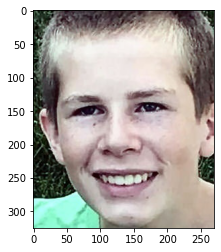

In [12]:
plt.imread(test_path+"/Autistic/"+covid_group[0])
plt.imshow(plt.imread(test_path+"/Autistic/"+covid_group[0]))

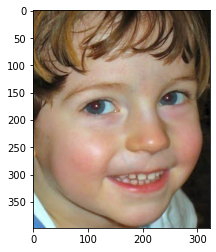

In [13]:
plt.imread(test_path+"/Non_Autistic/"+no_covid_group[0])
plt.imshow(plt.imread(test_path+"/Non_Autistic/"+no_covid_group[0]))

In [14]:
plt.imread(test_path+"/Autistic/"+covid_group[0]).shape

(325, 270, 3)

In [15]:
len(no_covid_group)

150

In [16]:
len(covid_group)

150

Checking general shape of images

In [17]:
dim1=[]
dim2=[]

for image_name in os.listdir(test_path+"/Autistic"):
    image=plt.imread(test_path+"/Autistic/"+image_name)
    d1,d2,q= image.shape
    dim1.append(d1)
    dim2.append(d2)

In [18]:
np.mean(dim1)

391.5133333333333

In [19]:
np.mean(dim2)

338.2266666666667

In [20]:
np.min(dim2)

150

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


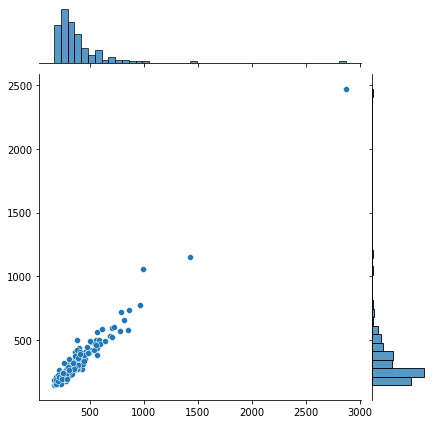

In [21]:
sns.jointplot(dim1, dim2)

In [22]:
image_shape=(224,224,3)

## Preparing the Data for the model

There is too much data for us to read all at once in memory. We can use some built in functions in Keras to automatically process the data, generate a flow of batches from a directory, and also manipulate the images.

### Image Manipulation

Its usually a good idea to manipulate the images with rotation, resizing, and scaling so the model becomes more robust to different images that our data set doesn't have. We can use the **ImageDataGenerator** to do this automatically for us. 

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [24]:
image_gen = ImageDataGenerator(  rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)

In [25]:
image_gen.flow_from_directory(train_path)

Found 2540 images belonging to 2 classes.


In [26]:
image_gen.flow_from_directory(test_path)

Found 300 images belonging to 2 classes.


# Creating the Model

## Custom Model

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, GlobalMaxPooling2D

In [28]:
model=Sequential()

In [29]:
model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3,3),input_shape=image_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=512, kernel_size=(3,3),input_shape=image_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())


model.add(Dense(128))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation("sigmoid"))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [30]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0

In [32]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [33]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [34]:
early_stop=EarlyStopping(monitor="val_loss",patience=5)

In [35]:
batch_size = 32

In [36]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=(224,224),
                                            color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary', 
                                               )

Found 2540 images belonging to 2 classes.


In [37]:
val_gen= ImageDataGenerator(rescale=1/255)
val_image_gen = val_gen.flow_from_directory(val_path,
                                                target_size=(224,224),
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                class_mode='binary',
                                                )

Found 100 images belonging to 2 classes.


In [38]:
test_gen= ImageDataGenerator(rescale=1/255)
test_image_gen = test_gen.flow_from_directory(test_path,
                                               target_size=(224,224),
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',
                                              shuffle= False,
                                              )

Found 300 images belonging to 2 classes.


In [39]:
results = model.fit_generator(train_image_gen,epochs=100,
                              validation_data=val_image_gen,
                             callbacks=[early_stop, learning_rate_reduction ])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
80/80 [==============================] - 922s 11s/step - loss: 0.7980 - accuracy: 0.5071 - val_loss: 0.6928 - val_accuracy: 0.5100
Epoch 2/100
80/80 [==============================] - 33s 408ms/step - loss: 0.6882 - accuracy: 0.5272 - val_loss: 0.6767 - val_accuracy: 0.5700
Epoch 3/100
80/80 [==============================] - 33s 407ms/step - loss: 0.6888 - accuracy: 0.5579 - val_loss: 0.6734 - val_accuracy: 0.5900
Epoch 4/100
80/80 [==============================] - 33s 406ms/step - loss: 0.6682 - accuracy: 0.6189 - val_loss: 0.6252 - val_accuracy: 0.6900
Epoch 5/100
80/80 [==============================] - 33s 406ms/step - loss: 0.6329 - accuracy: 0.6563 - val_loss: 0.5994 - val_accuracy: 0.7000
Epoch 6/100
80/80 [==============================] - 33s 409ms/step - loss: 0.6093 - accuracy: 0.6791 - val_loss: 0.5659 - val_accuracy: 0.7200
Epoch 7/100
80/80 [==============================] - 33s 405ms/step - loss: 0.5899 - accuracy: 0.6969 - val_loss: 0.5111 - val_accuracy: 

In [40]:
losses = pd.DataFrame(model.history.history)

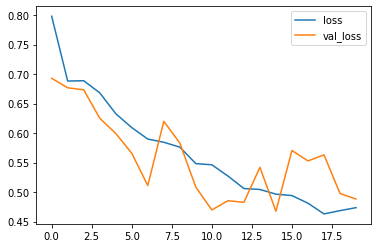

In [41]:
losses[['loss','val_loss']].plot()

In [42]:
from tensorflow.keras.preprocessing import image

In [ ]:
test_gen= ImageDataGenerator(rescale=1/255)
test_image_gen = test_gen.flow_from_directory(test_path,
                                               target_size=(224,224),
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',
                                              shuffle= False,
                                              )
test_image_gen.reset()

In [43]:
test_steps_per_epoch = np.math.ceil(test_image_gen.samples / test_image_gen.batch_size)
model.evaluate(test_image_gen,steps=test_steps_per_epoch, batch_size=batch_size)

10/10 [==============================] - 43s 5s/step - loss: 0.4326 - accuracy: 0.8067


[0.43258732557296753, 0.8066666722297668]

In [44]:
predictions = model.predict(test_image_gen, batch_size=batch_size)

In [45]:
true_classes = test_image_gen.classes
class_labels = list(test_image_gen.class_indices.keys())  

In [46]:
predicted_classes=predictions > 0.5

In [47]:
test_real_values=test_image_gen.classes

In [48]:
from sklearn.metrics import classification_report,confusion_matrix

In [49]:
print(classification_report(test_real_values,predicted_classes))

              precision    recall  f1-score   support

           0       0.84      0.76      0.80       150
           1       0.78      0.85      0.82       150

    accuracy                           0.81       300
   macro avg       0.81      0.81      0.81       300
weighted avg       0.81      0.81      0.81       300



In [51]:
confusion_matrix(test_real_values,predicted_classes)

array([[114,  36],
       [ 22, 128]])

## Using VGG16 Pretrained Model

In [52]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import optimizers , layers, applications
from tensorflow.keras.models import Model

In [54]:
trained_model= VGG16(input_shape=image_shape, include_top=False, weights="imagenet")
last_layer = trained_model.get_layer('block5_pool')
last_output = last_layer.output

In [55]:
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model_with_pretrained = Model(trained_model.input, x)

model_with_pretrained.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
              metrics=['accuracy'])



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [56]:
model_with_pretrained.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [57]:
results = model_with_pretrained.fit(train_image_gen,epochs=100,
                              validation_data=val_image_gen,
                              callbacks=[early_stop, learning_rate_reduction], validation_steps=100//batch_size,
                              steps_per_epoch=2540//batch_size)

Epoch 1/100
79/79 [==============================] - 56s 578ms/step - loss: 0.6454 - accuracy: 0.6443 - val_loss: 0.6282 - val_accuracy: 0.6771
Epoch 2/100
79/79 [==============================] - 42s 522ms/step - loss: 0.5485 - accuracy: 0.7165 - val_loss: 0.4890 - val_accuracy: 0.8021
Epoch 3/100
79/79 [==============================] - 41s 522ms/step - loss: 0.4709 - accuracy: 0.7791 - val_loss: 0.6227 - val_accuracy: 0.6875
Epoch 4/100
79/79 [==============================] - 42s 525ms/step - loss: 0.4731 - accuracy: 0.7823 - val_loss: 0.5697 - val_accuracy: 0.6875

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/100
79/79 [==============================] - 42s 523ms/step - loss: 0.4138 - accuracy: 0.8150 - val_loss: 0.4569 - val_accuracy: 0.8021
Epoch 6/100
79/79 [==============================] - 42s 524ms/step - loss: 0.3810 - accuracy: 0.8337 - val_loss: 0.4808 - val_accuracy: 0.7604
Epoch 7/100
79/79 [==============================] - 42

In [58]:
losses = pd.DataFrame(model_with_pretrained.history.history)

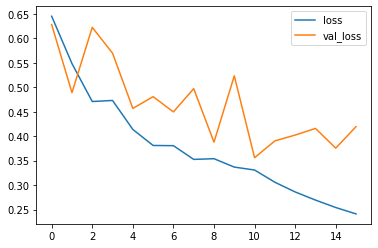

In [59]:
losses[['loss','val_loss']].plot()

In [60]:
from tensorflow.keras.preprocessing import image

In [61]:
test_gen= ImageDataGenerator(rescale=1/255)
test_image_gen = test_gen.flow_from_directory(test_path,
                                               target_size=(224,224),
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',
                                              shuffle= False,
                                              )
test_image_gen.reset()

Found 300 images belonging to 2 classes.


In [62]:
pred_probabilities = model_with_pretrained.predict(test_image_gen,steps=test_steps_per_epoch, batch_size=batch_size)

In [63]:
test_steps_per_epoch = np.math.ceil(test_image_gen.samples / test_image_gen.batch_size)
model_with_pretrained.evaluate(test_image_gen,steps=test_steps_per_epoch, batch_size=batch_size)

10/10 [==============================] - 2s 153ms/step - loss: 0.3298 - accuracy: 0.8600


[0.329816609621048, 0.8600000143051147]

In [64]:
true_classes = test_image_gen.classes
class_labels = list(test_image_gen.class_indices.keys()) 

In [65]:
predicted_classes=pred_probabilities > 0.5

In [66]:
test_real_values=test_image_gen.classes

In [67]:
print(classification_report(test_real_values,predicted_classes))

              precision    recall  f1-score   support

           0       0.80      0.95      0.87       150
           1       0.94      0.77      0.85       150

    accuracy                           0.86       300
   macro avg       0.87      0.86      0.86       300
weighted avg       0.87      0.86      0.86       300



In [68]:
confusion_matrix(test_real_values,predicted_classes)

array([[143,   7],
       [ 35, 115]])